# Document and Node Embeddings

As a last part of the analysis we wanted to test if it was possible to create a meaningful vector representation of our data in a vector space. To do so we used two techniques - `node2vec` and `doc2vec` to model different aspect of the data. While they are similar to other methods we've used in the sense that they can help us understand patterns and relations in the data, they have the benefit of very easily being converted to a low dimensional space where one can calculate the similarities between units of analysis using for example the cosine or euclidian distance. The rest of this page is structured as follows: first, we compute the document embeddings and give a brief explanation of the method. Next, we do the same for node embeddings. We finish with visualization using UMAP. However, we think that the best way to interact and understand the embeddings is in [`tensorboard`](https://www.tensorflow.org/tensorboard) and we have hosted the data on the following two links bellow for you to play around with. We recommend testing both PCA and UMAP for dimensionality reduction.

* [Document Embeddings](https://raw.githubusercontent.com/MatPiq/social-graphs-embeddings-data/main/document_config.json)
* [Node Embeddings](https://raw.githubusercontent.com/MatPiq/social-graphs-embeddings-data/main/node_config.json)

In [2]:
#Read data and import relevant modules
from gensim.models.doc2vec import Doc2Vec
from collections import namedtuple
from node2vec import Node2Vec
import networkx as nx
import numpy as np
import umap
import umap.plot
from bokeh.plotting import show
import random
import pandas as pd
data = pd.read_pickle('Final_df.pickle')
edge_list = pd.read_pickle('Final_edge_list.pickle')
node_attributes = pd.read_pickle('Final_node_attr.pickle')

In [3]:
name_mapping = {'political_science':'POLISCY', 'economics':'ECON',
                'anthropology':'ANTHRO', 'psychology':'PSY', 'sociology':'SOC'}

data['title_dic'] = data[['title', 'parent']].apply(lambda row: f"{row['title']}_{name_mapping[row['parent']]}", axis=1)

## Document Embeddings

Document embeddings is an extension of `word2vec` which allows us to estimate a vectorial representation of documents using shallow neural networks {cite}`le2014distribute, mikolov2013efficien`. In our case the documents are represented by the wikipedia articles corresponding to the social science disciplines. The task of the network is to predict a word $w_t$ based on a defined amount of surrounding words $w_{t-\Delta}$ and $w_{t+\Delta}$ called the context, where $\Delta$ is the symmetric size of the context window. While this task is not necessarily very interesting in itself, it encourages the hidden layer to learn a numerical representation of the words that takes context into account. By also appending an indicator variable $x$ to each wikipedia page we simultaniously learn the representation of documents in the same latent vector space. In a paper by by {cite}`rheault2020word` for example, they showed that one can extract high-quality representations of the ideology of politicians and parties using a parliamentary corpora that can also be used for a variety of downstream tasks. Borrowing {cite}`rheault2020word`, figure we display the network architecture bellow.

![img](doc2vec.png)

To run `doc2vec` we first need to create a list of documents. Each document is a `namedtuple` containing the text and the indicator variable for the article. We also set several hypyerparameters, the most important being the dimensions of the hidden layer `vector_size`. Since the data is relatively small we set this 64, common for larger corpuses being in the range of 200-300.

In [4]:
#Create a list of documents and store relevant meta data
docs = []
doc_meta = []
#Define a document data obj
document_tup = namedtuple('Doc', 'words, tags')
for row in data.iterrows():
    #Ignore empty articles
    if isinstance(row[1]['cleaned_text'], str):
        docs.append(document_tup(row[1]['cleaned_text'].split(), 
                                 [row[1]['title_dic']]
                                 ))
        
        doc_meta.append([row[1]['title'], row[1]['title_dic'], row[1]['parent']])

doc_meta = pd.DataFrame(doc_meta, columns=['merge_key', 'article_name', 'discipline'])

In [14]:
def doc2vec(docs:namedtuple, vector_size, window, 
            min_count, workers, epochs):
    """
    Fits the document doc2vec model on a list of namedtuples.
    Returns the trained model.
    """
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    print(f'Starting to build the vocabulary based on {len(docs)} documents...')
    model.build_vocab(docs)
    print(f'Starting to train the model for {epochs} epochs and with vector size {vector_size}...')
    model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)
    return model

doc2vec_fitted = doc2vec(docs, vector_size=100, window=20, min_count=10, workers=8, epochs=5)

Starting to build the vocabulary based on 4302 documents...
Starting to train the model for 5 epochs and with vector size 100...


In [15]:
#Extract the document embeddings from trained model
doc_labs = list(doc2vec_fitted.dv.key_to_index.keys())
doc_embs = np.array([doc2vec_fitted.dv[lab] for lab in doc_labs])
doc_df = pd.DataFrame(doc_embs, index = doc_labs)
#Save the embeddings and labels locally as TSV
doc_df.to_csv('document_embeddings.tsv', sep = '\t')
doc_meta.to_csv('document_meta.tsv', sep = '\t')

## Node Embeddings

`Node2vec` was introduced in {citep}`grover2016node2vec` and is in many ways just like `doc2vec` explained above with the noteable difference that we are working with a graph instead of document of text. The trick of `node2vec` is to first create a representation of the graph as a string that encodes the connection between nodes. As visualized bellow, this is done by taking random walks in the graph and letting the connections form artificial "sentences". This leads to a data structure that can be passed to the normal `word2vec` model and generates one embedding corresponding to each node. 

<img src="https://miro.medium.com/max/1838/1*GbZk_M_HqCu8Y99J_FzhQw.gif" width="800"> 

Before running the model we load the edge list and create the undirected `networkx` graph object and select the giant connected component.

In [7]:
#Create subgraph and extract giant component
G = nx.Graph()
G.add_edges_from(edge_list)
gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(gcc[0])

In [8]:
#Train the model
node2vec_fitted = Node2Vec(G, dimensions=100, walk_length=40, num_walks=200, workers=8).fit()

Generating walks (CPU: 8): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


In [9]:
#Extract embeddings, create meta data and save locally
node_labs = list(node2vec_fitted.wv.key_to_index.keys())
node_embs = [node2vec_fitted.wv[lab] for lab in node_labs]
node_df = pd.DataFrame(node_embs, index = node_labs)
node_meta = pd.DataFrame(node_labs, columns=['merge_key']).merge(doc_meta, how='left').dropna()
node_df = node_df.loc[node_df.index.isin(node_meta['merge_key'])]
#Save the embeddings and labels locally as TSV
node_meta = node_meta[['article_name', 'discipline']]

node_meta.to_csv('node_meta.tsv', sep = '\t', index=False)
node_df.to_csv('node_embeddings.tsv', sep='\t', index=False, header=False)

## Analysis of embeddings

Bellow we create two plot and reduce the dimensions of the embeddings using the Uniform Manifold Approximation Projection for Dimension Reduction technique (UMAP) introducted in {cite}`mcinnes2018umap`. They show that Umap tends to be good at preserving the global structure of the embedding space while at the same time being fast.  

Altough one should probably be cautious when interpreting embeddings and especially their projections onto 2D-space, we generally find that both models have generated intuitive and useful representations of the data they were trained on. Moreover, the patterns to a large extent coincide with results from the previous methods we have implemented. In the plot based on node embeddings, the different disciplines are clearly clustered in groups. Looking at the y-axis, the disciplines furthest apart from each other are economics and anthropology, while political science and sociology are mostly situated in the middle. One potential explanation for this pattern is their methodological and epistemological differences. Economics comes from a positivist tradition and mostly uses mathematics both in empirical and theoretical work while Anthropology is on the other side of the same spectra. Political Science and Sociology on the other hand, tend to use both quantitative and qualitative methods and be grounded in both interpretivism and positivism. A result that perhaps challenges this hypothesis is the proximity of Psychology and Anthropology. In this case, their relative positions rather seem to stem from overlap in subject matter rather than the particular methodological or epistemological approach. 

In [10]:
def plot_umap(embeddings:np.array, meta:pd.DataFrame):
    """
    Reduces dimensionality to two dims using UMAP 
    and creates interactive plot.
    """
    #uggly solution to remove discipline from article name in this plot
    mapper = umap.UMAP(n_neighbors=15, min_dist=0.01, 
                       n_components=2, metric='cosine').fit(embeddings)
    
    p = umap.plot.interactive(mapper, labels=meta.discipline, alpha = 1,
                          point_size=3, theme='inferno', hover_data=meta,
                          interactive_text_search_columns=['article_name', 'discipline'],
                          interactive_text_search=True, 
                          interactive_text_search_alpha_contrast = 0.95)

    print('Drawing 20 random article that you can search for:')
    suggestions = random.sample(meta['article_name'].tolist(), 20)
    print(suggestions)
    print('-'*66)
    print('You can also just search for a discipline')
    umap.plot.output_notebook()
    show(p)
    

In [13]:
plot_umap(node_embs, node_meta)

Drawing 20 random article that you can search for:
['experimental_economics_ECON', 'celeb_jihad_POLISCY', 'inter-municipal_cooperation_POLISCY', 'names_for_the_human_species_ANTHRO', 'religion_ANTHRO', 'far-right_politics_POLISCY', 'women-are-wonderful_effect_PSY', 'discrete_choice_ECON', 'mapping_controversies_SOC', 'dispersed_knowledge_ECON', 'manorialism_ANTHRO', 'real-time_economy_ECON', 'responsibility_to_protect_POLISCY', 'martens_centre_POLISCY', 'universe_(economics)_ECON', 'cultural_movement_ANTHRO', 'vulnerable_adult_SOC', 'sustainability_standards_and_certification_SOC', 'kansas_city_preventive_patrol_experiment_POLISCY', 'archon_fung_POLISCY']
------------------------------------------------------------------
You can also just search for a discipline


Loading BokehJS ...

At first glance, the document embeddings might seem completely random by the position of the points. However, when analysing the data closer we find this not to be the case. By looking at the neighbours of some Wiki page, i.e. the points closest in space, we find that they are often similar in content. As an example, if we look at the most similar pages to the Anthropology page [mobile_ethnography](https://en.wikipedia.org/wiki/Mobile_ethnography) which is a qualitative method that utilizes smartphones we find pages to similar digital methods both in Anthropology and in other fields. In summary, we think that one possible interpretation of these findings is that academic disciplines, as understood through Wikipedia, tend to explicitly reference to their own discipline much more than to others. However, this is cannot be fully explained by there being no overlap in substantive content as seen by the doc2vec results.

In [12]:
plot_umap(doc_embs, doc_meta[['article_name', 'discipline']])

Drawing 20 random article that you can search for:
['kurt_heinrich_wolff_SOC', 'noctcaelador_PSY', 'rosa_brooks_POLISCY', 'james–lange_theory_PSY', 'roy_model_ECON', 'food_competition_SOC', 'social_indicators_research_SOC', 'gish_gallop_POLISCY', 'irish_honours_system_ANTHRO', 'rosa_luxemburg_foundation_POLISCY', 'invoke_malaysia_POLISCY', "mandeville's_paradox_ECON", 'piréz_people_POLISCY', 'sexual_jihad_POLISCY', 'distributive_tendency_POLISCY', 'paradox_of_thrift_ECON', 'bratachari_movement_ANTHRO', 'consistent_pricing_process_ECON', 'informational_listening_SOC', 'consummation_ANTHRO']
------------------------------------------------------------------
You can also just search for a discipline


Loading BokehJS ...

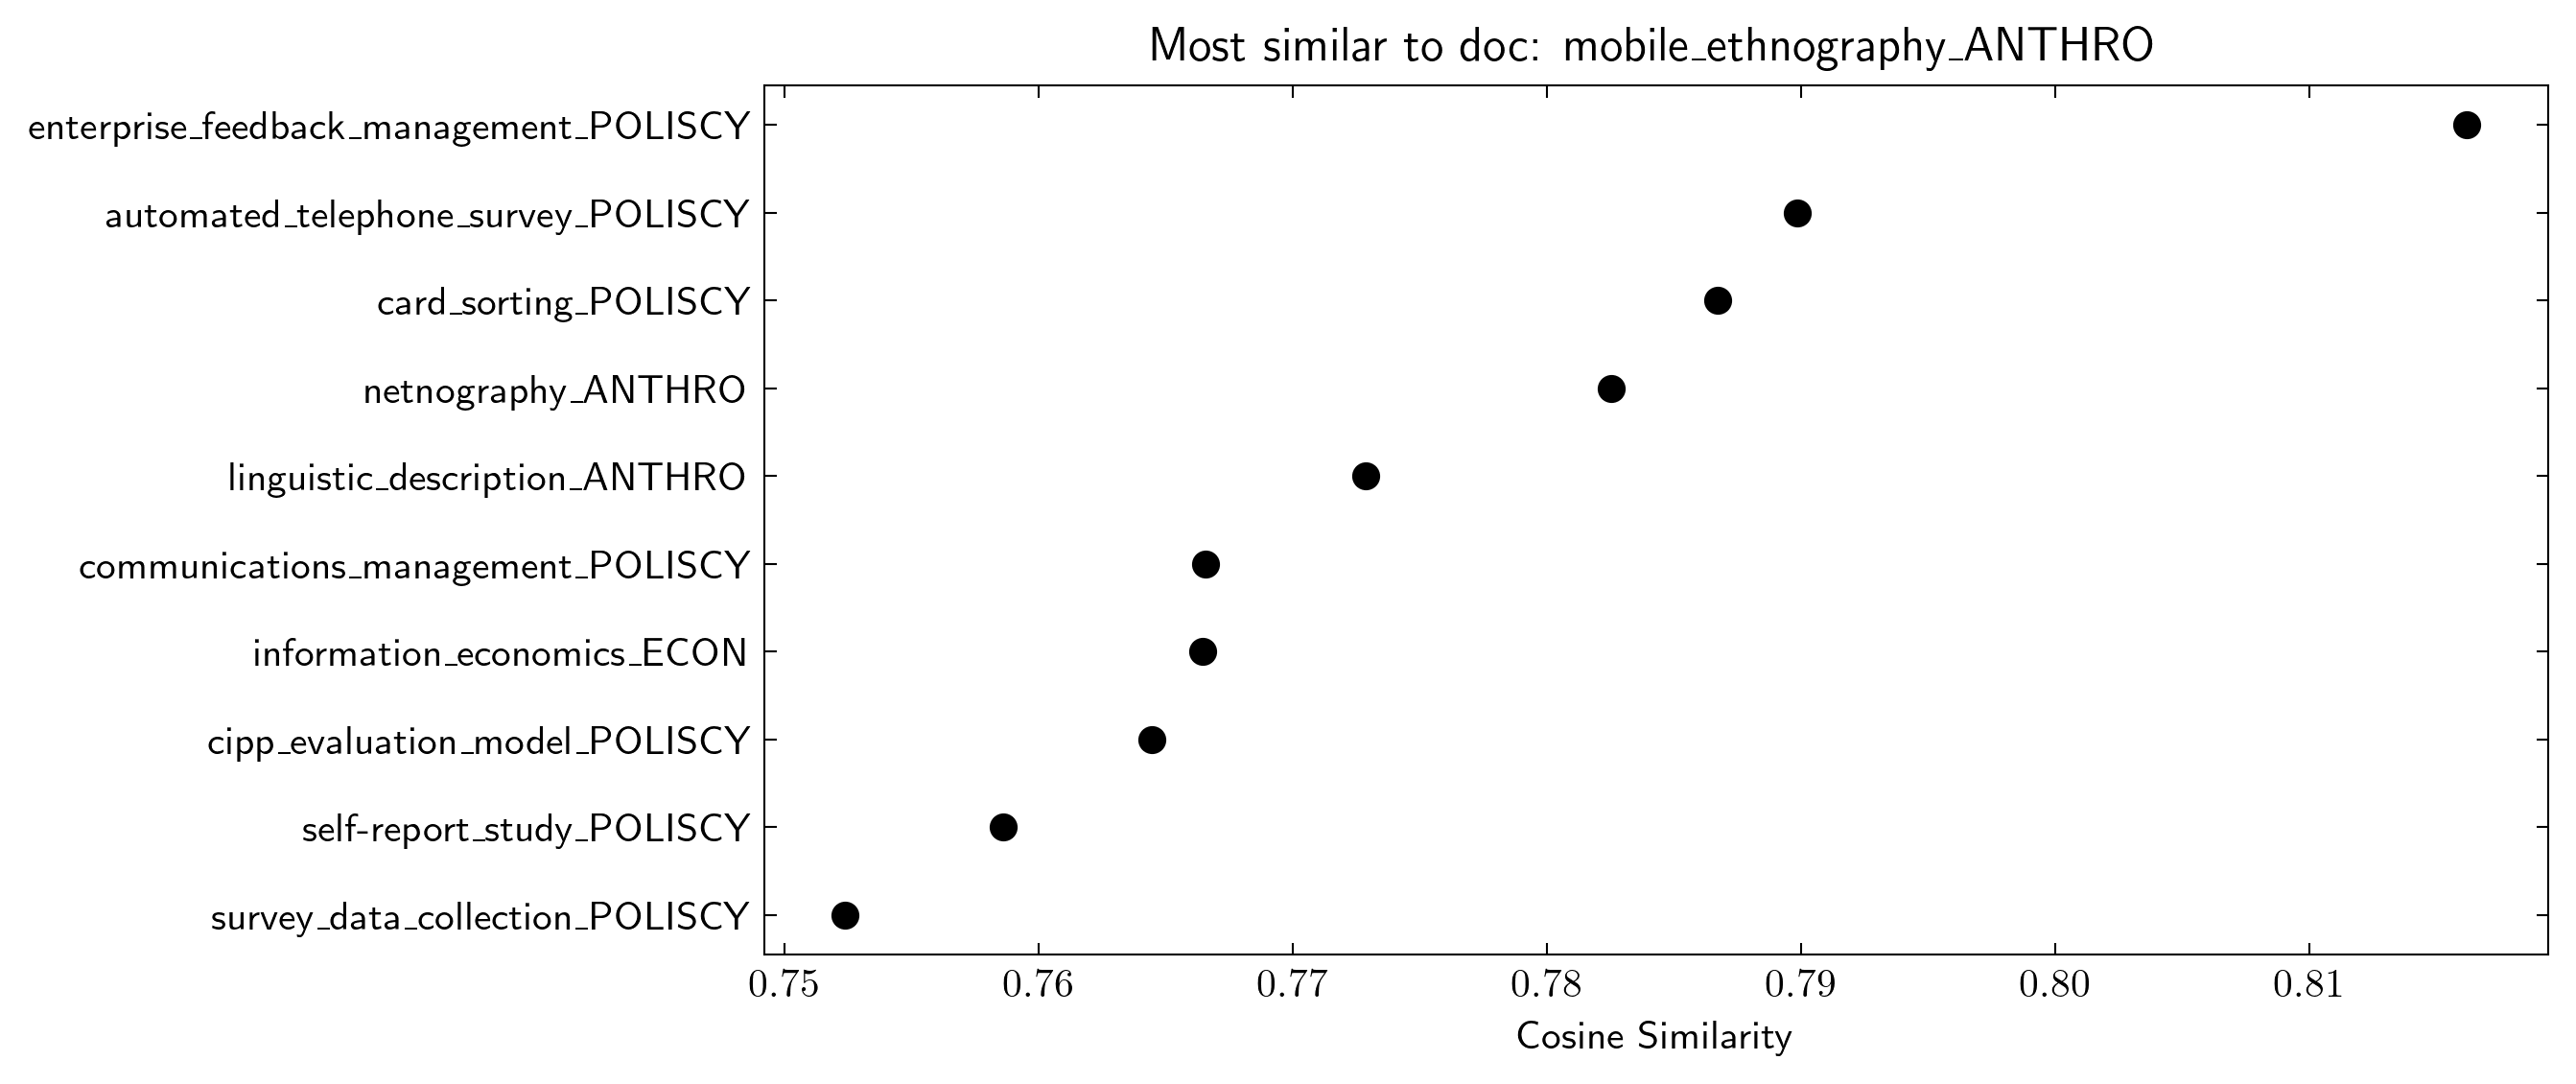

In [192]:
import matplotlib.pyplot as plt
def plot_most_similar(model, query, embedding_type = 'doc'):
    with plt.style.context('science'):
        fig, ax = plt.subplots(dpi=300, figsize=(8,4))
        if embedding_type == 'doc':
            res = reversed(model.dv.most_similar(query))
        if embedding_type == 'word':
            res = reversed(model.wv.most_similar(query))
        for x, y in res:
            ax.plot(y,x, "ko")
            ax.set_title(f'Most similar to {embedding_type}: {query}')
            ax.set_xlabel('Cosine Similarity')
            ax.minorticks_off()

plot_most_similar(doc2vec_fitted, query = 'mobile_ethnography_ANTHRO')        